In [0]:
!/opt/bin/nvidia-smi
!nvcc --version

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

In [3]:
!wget 'https://storage.googleapis.com/sherlock_datasets/CASIA_ELA.zip'

--2020-04-12 10:57:28--  https://storage.googleapis.com/sherlock_datasets/CASIA_ELA.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 2a00:1450:4013:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1388019404 (1.3G) [application/zip]
Saving to: ‘CASIA_ELA.zip’

CASIA_ELA.zip       100%[===================>]   1.29G   199MB/s    in 6.9s    

2020-04-12 10:57:35 (191 MB/s) - ‘CASIA_ELA.zip’ saved [1388019404/1388019404]



In [0]:
!unzip -o -q CASIA_ELA.zip

In [0]:
def exportStageTo(learn, path):
    learn.export()
    copyfile(path/'export.pkl', path/'export-ela.pkl')

def restoreStageFrom(path):
    # Restore a backup
    copyfile(path/'export-ela.pkl', path/'export.pkl')
    return load_learner(path)

In [4]:
path = Path("/home/tiago4k_gmail_com/CASIA_ELA"); path

PosixPath('/home/tiago4k_gmail_com/CASIA_ELA')

In [0]:
path_to_test = Path("/home/tiago4k_gmail_com/CASIA_ELA/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
# Batch Size
bs = 28
# Image size, 448x448
size = 448
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', 
                                  ds_tfms = tfms, size=size, bs=bs)

data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

In [0]:
learn = cnn_learner(data, models.resnet101, metrics=[accuracy, error_rate])

In [0]:
learn.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', 
                                                     monitor='accuracy', 
                                                     name='ela-1')])
learn.save('ela-stage-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.365254,0.277729,0.903915,0.096085,03:48
1,0.260670,0.191525,0.925534,0.074466,03:41
2,0.236515,0.193417,0.925054,0.074946,03:40
3,0.191006,0.162615,0.940187,0.059813,03:41
4,0.155307,0.144232,0.944271,0.055729,03:40
5,0.160379,0.123074,0.949075,0.050925,03:41
6,0.133808,0.114321,0.954120,0.045880,03:41
7,0.115641,0.116112,0.951717,0.048282,03:40
8,0.110734,0.111505,0.954600,0.045400,03:40
9,0.102154,0.109611,0.956041,0.043959,03:41


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

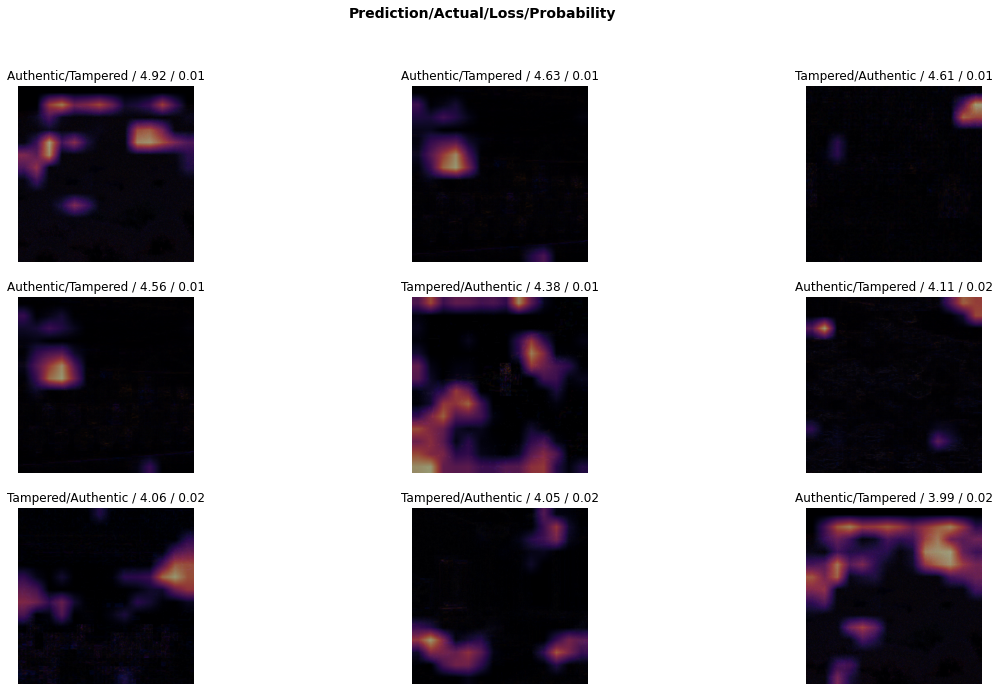

In [0]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

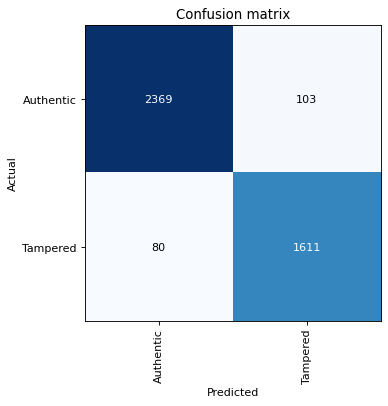

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


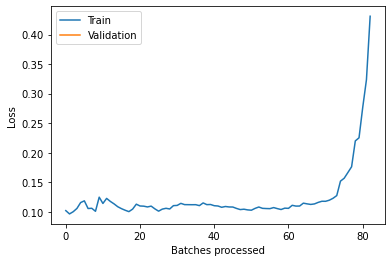

In [0]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


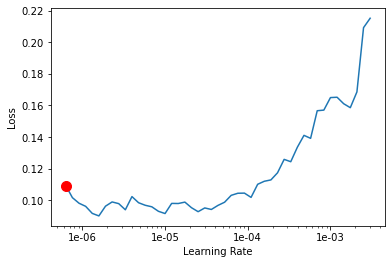

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.destroy()

In [0]:
learn.load('/home/tiago4k_gmail_com/ela-stage-1')

In [0]:
learn.unfreeze()

In [11]:
learn.fit_one_cycle(30, max_lr=slice(1e-5,1e-6))
learn.save('ela-stage-2')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.106035,0.109086,0.956762,0.043238,03:08
1,0.110561,0.109605,0.955321,0.044679,03:02
2,0.099019,0.108704,0.957723,0.042277,03:02
3,0.103744,0.105218,0.958924,0.041076,03:02
4,0.097708,0.106384,0.957242,0.042758,03:02
5,0.098855,0.102559,0.959885,0.040115,03:02
6,0.090154,0.104017,0.958203,0.041797,03:02
7,0.108351,0.106696,0.956762,0.043238,03:02
8,0.087434,0.097680,0.962287,0.037713,03:02
9,0.095443,0.099661,0.958443,0.041557,03:02


In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

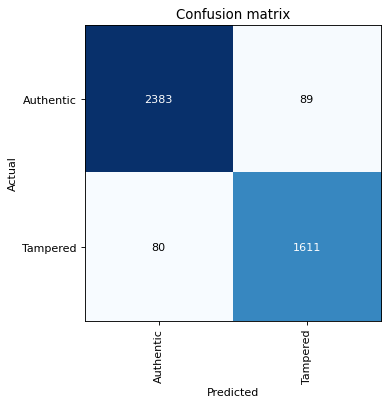

In [13]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

Get Predictions and accuracy on the test dataset

In [0]:
learn = load_learner(path)

In [14]:
path = '/home/tiago4k_gmail_com/CASIA_ELA/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            # if conf >=65:
            #     print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/home/tiago4k_gmail_com/CASIA_ELA/Test/Tampered/
/home/tiago4k_gmail_com/CASIA_ELA/Test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [16]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
477/502. Accuracy = 95.02%
Images Classified As Tampered
334/344. Accuracy = 97.09%


In [17]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 96.911%


In [0]:
learn.export()

Predict on a single image

In [42]:
img = open_image('/home/tiago4k_gmail_com/text_fake.JPG')
pred_class,pred_idx,confidence = learn.predict(img); pred_class

Category Authentic